<a href="https://colab.research.google.com/github/mavivi95/overfittingLipschitzBound/blob/main/validationMethodLBExperimentoACIFAR_codigolimpio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__) # Verificar 2.9.0

2.18.0


In [ ]:
# Manejo de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# TensorFlow y Keras

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Add, Flatten, Dense, MaxPooling2D, Input, Add, Dropout
from tensorflow.keras import regularizers as l
from tensorflow.keras.regularizers import l2

# Métricas y evaluación
from sklearn import metrics
from sklearn.model_selection import KFold, ShuffleSplit, GridSearchCV

# Funciones matemáticas
from numpy.linalg import norm
from scipy import interpolate

# Otros
import os
import time

In [ ]:
print(os.getcwd())

/content


In [ ]:
os.chdir('/content/drive/MyDrive/Tesis Maestría /Codigos depurados/ExperimentoCIFAR')
print(os.getcwd())

/content/drive/MyDrive/Tesis Maestría /Codigos depurados/ExperimentoCIFAR


In [ ]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

def load_data():
    # Cargar el dataset CIFAR-10
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()

    # Normalizar los datos entre 0 y 1
    X_train, X_test = X_train / 255.0, X_test / 255.0

    # Convertir las etiquetas a codificación one-hot
    y_train_onehot = to_categorical(y_train)
    y_test_onehot = to_categorical(y_test)

    # Mostrar información sobre los datos
    print(f'Conjunto de datos cargados')
    print(f'Tamaño imágenes de entrenamiento: {X_train[:25000].shape}')
    print(f'Tamaño imágenes de test: {X_test.shape}')
    print(f'Datos por cada etiqueta en X_train: {np.bincount(y_train[:25000].flatten())}')

    # Retornar los datos (tomando los primeros 10,000 ejemplos si es necesario)
    return X_train[:25000], X_test, y_train_onehot[:25000], y_test_onehot, y_train[:25000].flatten(), y_test.flatten()


In [ ]:
X_train, X_test, y_train_onehot, y_test_onehot, y_train, y_test = load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step
Conjunto de datos cargados
Tamaño imágenes de entrenamiento: (25000, 32, 32, 3)
Tamaño imágenes de test: (10000, 32, 32, 3)
Datos por cada etiqueta en X_train: [2491 2518 2515 2522 2490 2411 2537 2530 2507 2479]


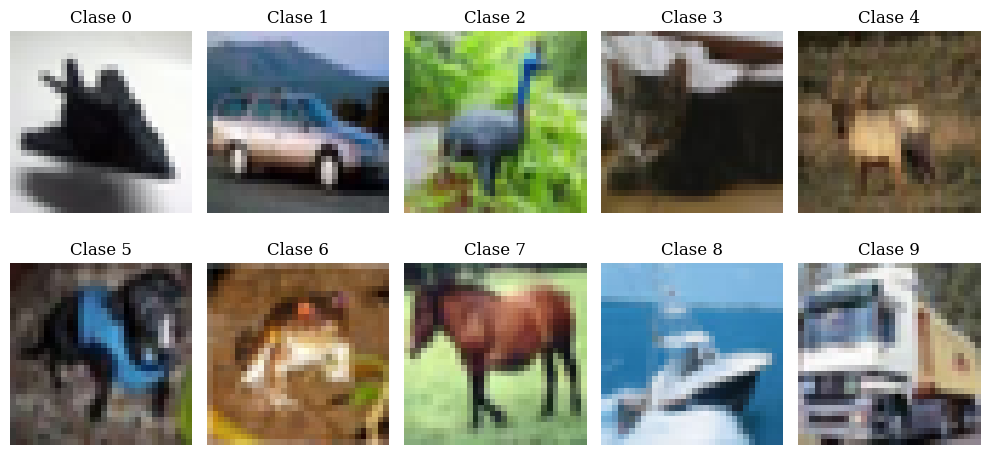

In [ ]:
# Crear una figura con subplots
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(10, 5))

# Aplanar las etiquetas para indexar correctamente
y_train_flat = y_train.flatten()

# Mostrar la primera imagen de cada clase
ax = ax.flatten()
for i in range(10):
    # Encontrar el índice de la primera ocurrencia de la clase `i`
    idx = np.where(y_train_flat == i)[0][0]
    img = X_train[idx]  # Seleccionar la imagen correspondiente

    # Mostrar la imagen en el subplot correspondiente
    ax[i].imshow(img)
    ax[i].set_title(f'Clase {i}')
    ax[i].axis('off')  # Ocultar los ejes

# Mostrar la figura
plt.tight_layout()
plt.show()


## Modelo con $n$ saltos residuales convolucionales

In [ ]:
def skip_connection(conv_input, n, filters, kernel_size,
                    regularizer, dropout_rate):
    """
    Crea capas convolucionales con conexiones residuales y dropout.

    Args:
        conv_input: Tensor de entrada.
        n: Número de bloques residuales.
        filters: Número de filtros para las capas convolucionales.
        kernel_size: Tamaño del kernel.
        regularizer: Regularizador L1 o L1_L2.
        dropout_rate: Tasa de dropout.

    Returns:
        Tensor de salida con conexiones residuales.
    """
    if n >= 2:
        # Capa convolucional con dropout
        res_conv = Dropout(dropout_rate)(Conv2D(
            filters, kernel_size, activation='relu', padding='same', kernel_regularizer=regularizer
        )(conv_input))
        # Conexión residual
        return skip_connection(Add()([conv_input, res_conv]), n - 1, filters, kernel_size, regularizer, dropout_rate)

    # Última capa convolucional con dropout
    res_conv_final = Dropout(dropout_rate)(Conv2D(
        filters, kernel_size, activation='relu', padding='same', kernel_regularizer=regularizer
    )(conv_input))

    # Retorno final con conexión residual
    return Add()([conv_input, res_conv_final])

In [ ]:
# Función para cargar el modelo
def load_model(n, filters, kernel_size, regular_l, dropout_rate):
    """
    Construye un modelo con capas convolucionales, conexiones residuales, dropout y regularización.

    Args:
        n: Número de bloques residuales.
        filters: Número de filtros en las capas convolucionales.
        kernel_size: Tamaño del kernel.
        regular_l: Regularización L1, L2 o L1_L2.
        dropout_rate: Tasa de dropout.

    Returns:
        Modelo compilado de TensorFlow.
    """
    tf.keras.backend.clear_session()

    # Entrada para imágenes de CIFAR-10 (32x32x3)
    inputs = Input(shape=(32, 32, 3))

    # Primera capa convolucional
    conv1 = Dropout(dropout_rate)(Conv2D(
        filters, kernel_size, activation='relu', padding='same',
        kernel_regularizer=regular_l
    )(inputs))

    # Capas residuales
    skip_final = skip_connection(conv1, n, filters, kernel_size,
                                 regular_l, dropout_rate)

    # Pooling y capa densa final
    pool = MaxPooling2D(pool_size=(2, 2))(skip_final)
    flat = Flatten()(pool)
    outputs = Dense(10, activation='softmax', kernel_regularizer=regular_l)(flat)

    return Model(inputs=inputs, outputs=outputs, name='ConvNetCustomModel')


## Modelo general

In [ ]:
n_blocks = 5  # Número de bloques residuales convolucionales
filters = 64  # Número de filtros
kernel_size = (3, 3)  # Tamaño del kernel
regularization = l.l2(0)  # Regularización L2
dropout = 0 # Tasa de dropout

model = load_model(n=n_blocks,
                   filters=filters,
                   kernel_size=kernel_size,
                   regular_l=regularization,
                   dropout_rate=dropout)
model.summary()

Model: "ConvNetCustomModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 32, 32, 64)     │              0 │ dropout[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 32, 32, 64)     │              0 │ add[0][0],             │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 32, 32, 64)     │              0 │ add_1[0][0],           │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ add_2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 32, 32, 64)     │              0 │ add_2[0][0],           │
│                           │                        │                │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)          

 Total params: 350,282 (1.34 MB)

 Trainable params: 350,282 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

# Funciones regularización LBA

In [ ]:
# Función para calcular la norma espectral (Lipschitz) de una capa convolucional
def spectral_norm(layer, power_iterations=10):
    kernel = layer.kernel  # Shape (kH, kW, in_channels, out_channels)
    kernel_reshaped = tf.reshape(kernel, [-1, kernel.shape[-1]])  # (in*H*W, out)

    u = tf.random.normal([kernel_reshaped.shape[-1], 1])  # Vector inicial

    for _ in range(power_iterations):

        v = tf.linalg.matmul(kernel_reshaped, u, transpose_a=False)

        v /= tf.norm(v)
        u = tf.linalg.matmul(kernel_reshaped, v, transpose_a=True)
        u /= tf.norm(u)


    new_u = tf.linalg.matmul(u, kernel_reshaped, transpose_a=True, transpose_b = True)

    sigma = tf.linalg.matmul(new_u, v)

    return sigma.numpy()[0,0]

In [ ]:
# Custom Training Loop modificado
def train_model_with_dynamic_reg(model, X_train, y_train, X_val, y_val,
                                 epochs=30, regularization_flag = True):

    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.CategoricalCrossentropy()

    train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.CategoricalAccuracy()

    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        print(f"\nEpoca {epoch+1}/{epochs}")

        batch_size = 400

        # Batch training
        for step in range(len(X_train)//batch_size):  # Asumiendo batch_size=32
            with tf.GradientTape() as tape:
                # Forward pass
                logits = model(X_train[step*batch_size:(step+1)*batch_size], training=True)

                # Calcular pérdida + regularización dinámica
                loss = loss_fn(y_train[step*batch_size:(step+1)*batch_size], logits)
                if regularization_flag:
                  conv_layers = [l for l in model.layers if isinstance(l, Conv2D)][1:]
                  selected_layer = np.random.choice(conv_layers)
                  lipschitz_factor = spectral_norm(selected_layer)
                  reg_loss = lipschitz_factor * tf.nn.l2_loss(selected_layer.kernel)
                  total_loss = loss + reg_loss
                else:
                  total_loss = loss

            # Backpropagation
            gradients = tape.gradient(total_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            # Métricas
            train_acc_metric.update_state(y_train[step*batch_size:(step+1)*batch_size], logits)

        # Validación
        val_logits = model.predict(X_val, verbose=0)
        val_loss = loss_fn(y_val, val_logits)
        val_acc_metric.update_state(y_val, val_logits)

        # Guardar métricas
        history['loss'].append(total_loss.numpy())
        history['accuracy'].append(train_acc_metric.result().numpy())
        history['val_loss'].append(val_loss.numpy())
        history['val_accuracy'].append(val_acc_metric.result().numpy())

        if regularization_flag:
          print(f"Loss: {total_loss:.4f} (Reg: {reg_loss:.4f}), Val Loss: {val_loss:.4f}")
        else:
          print(f"Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")
        print(f"Acc: {train_acc_metric.result().numpy()}, Val Acc: {val_acc_metric.result().numpy()}")
    return history, model

# Modelo sin regularización

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 60
acc_train = []
acc_val = []
histories = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')

    # Crear modelo nuevo por pliegue

    n_blocks = 6  # Número de bloques residuales convolucionales
    filters = 64  # Número de filtros
    kernel_size = (3, 3)  # Tamaño del kernel
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       filters=filters,
                       kernel_size=kernel_size,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_dynamic_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, regularization_flag = False
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)

    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f}')

time_end_total = time.time()
# Resultados finales
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Epoca 1/60
Loss: 2.0604, Val Loss: 2.0564
Acc: 0.17125000059604645, Val Acc: 0.2547999918460846

Epoca 2/60
Loss: 1.7217, Val Loss: 1.7244
Acc: 0.2593249976634979, Val Acc: 0.31439998745918274

Epoca 3/60
Loss: 1.4933, Val Loss: 1.5797
Acc: 0.31671667098999023, Val Acc: 0.3558666706085205

Epoca 4/60
Loss: 1.3270, Val Loss: 1.4510
Acc: 0.358474999666214, Val Acc: 0.3885999917984009

Epoca 5/60
Loss: 1.2210, Val Loss: 1.3903
Acc: 0.39221999049186707, Val Acc: 0.4129199981689453

Epoca 6/60
Loss: 1.1570, Val Loss: 1.3270
Acc: 0.4195416569709778, Val Acc: 0.4333333373069763

Epoca 7/60
Loss: 1.0868, Val Loss: 1.2569
Acc: 0.442892849445343, Val Acc: 0.4510857164859772

Epoca 8/60
Loss: 1.0253, Val Loss: 1.2001
Acc: 0.4640749990940094, Val Acc: 0.4663499891757965

Epoca 9/60
Loss: 0.9669, Val Loss: 1.1912
Acc: 0.48335000872612, Val Acc: 0.48037776350975037

Epoca 10/60
Loss: 0.9148, Val Loss: 1.1603
Acc: 0.5010550022125244, Val Acc: 0.49233999848365784

Epoca 11/60
Lo

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

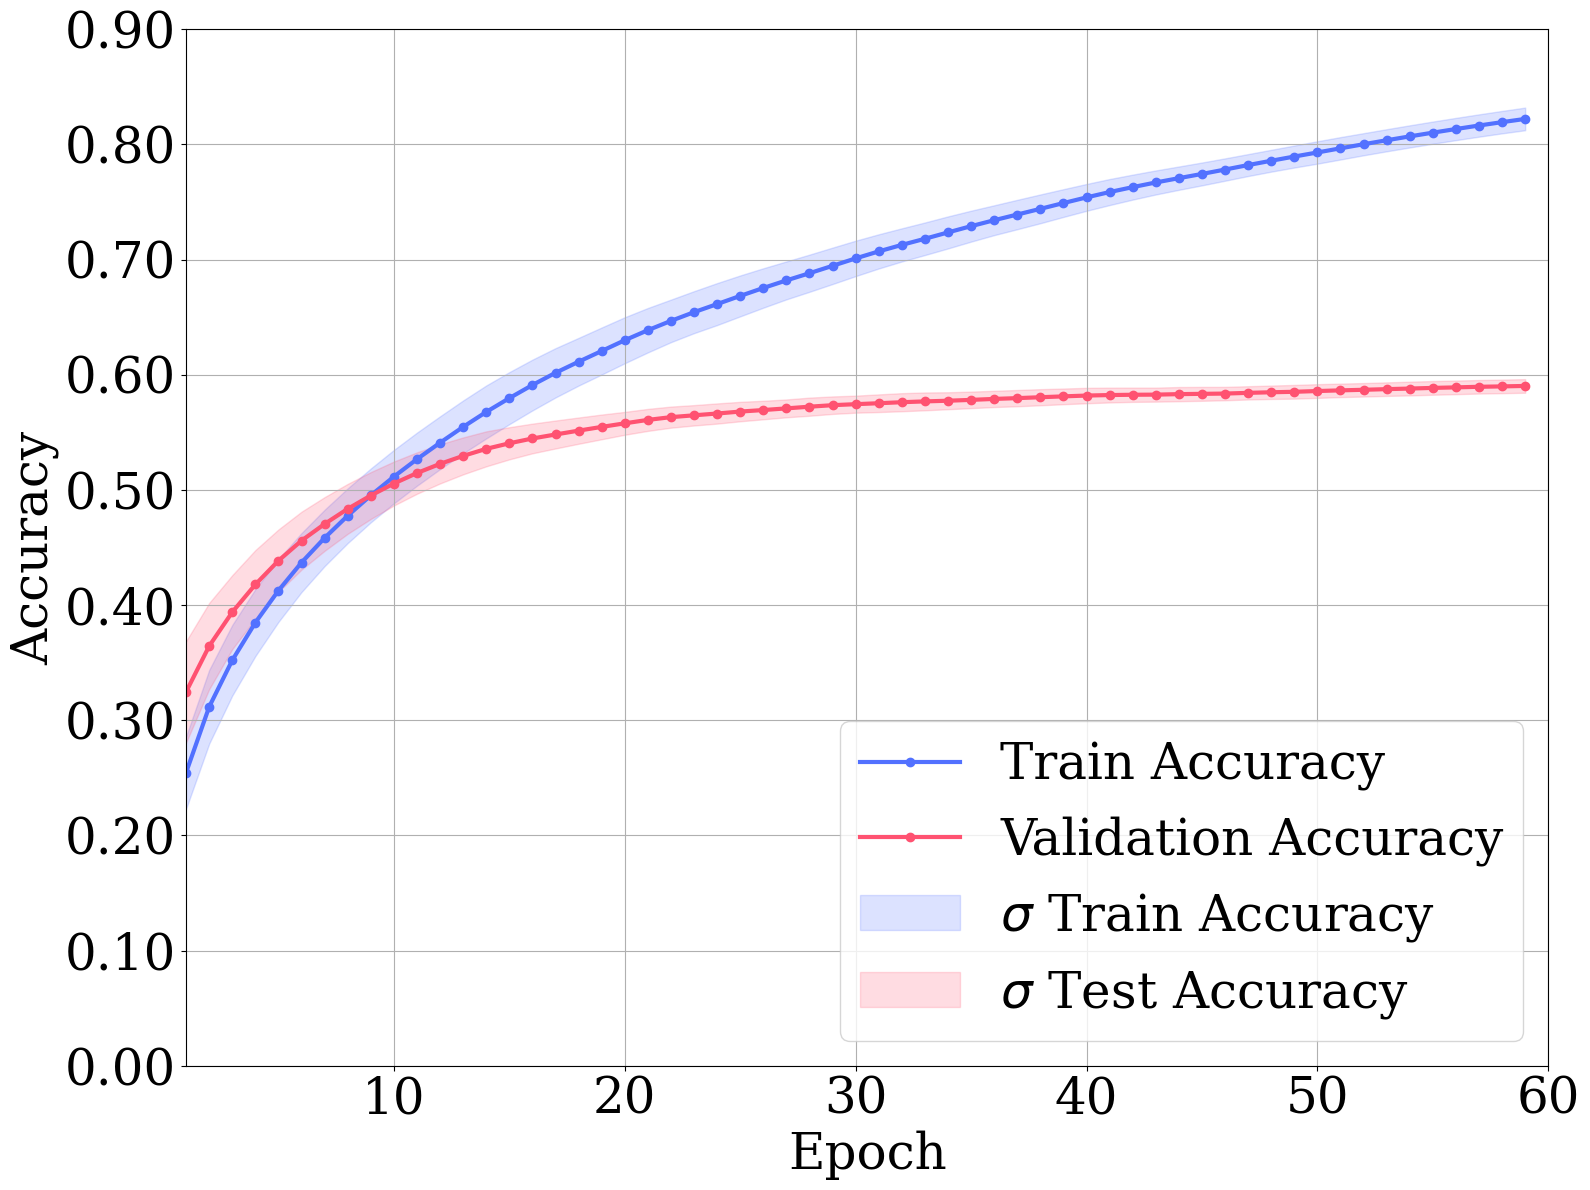

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(epochs),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(epochs),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ Test Accuracy',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim([0, 0.9])
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModeloSinRegularizacion' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

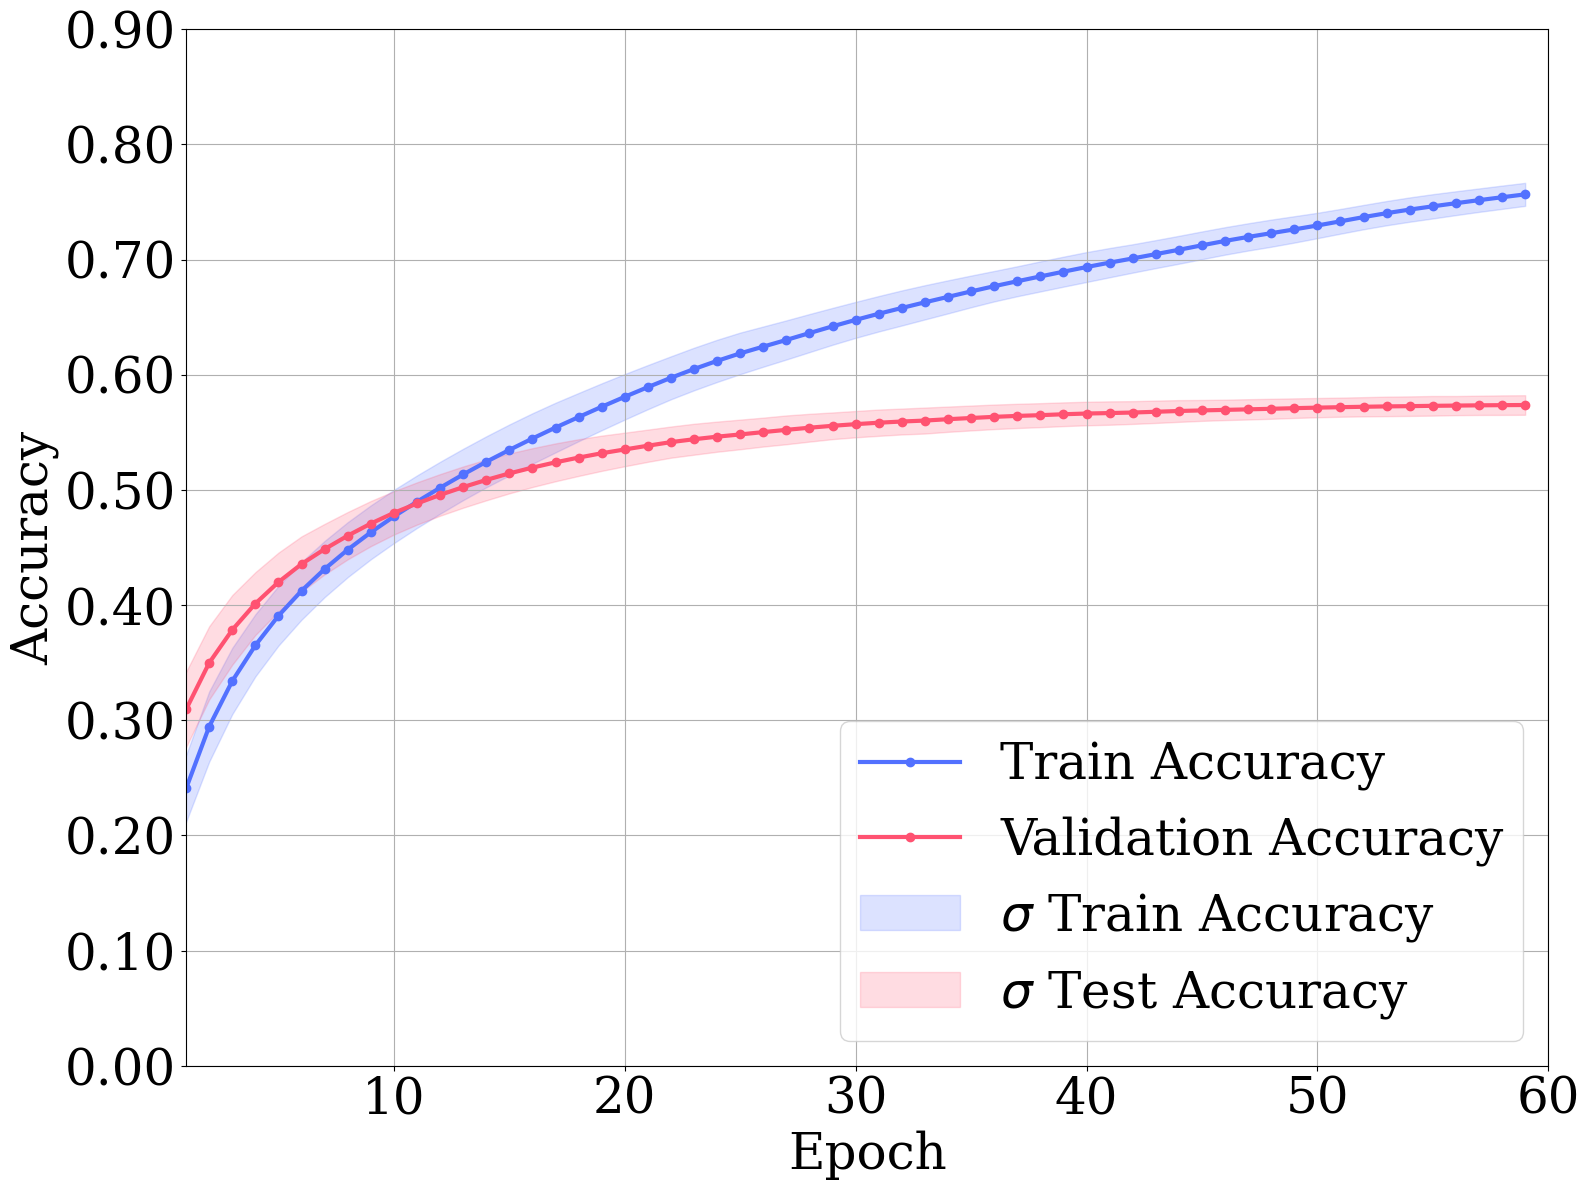

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(epochs),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(epochs),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ Test Accuracy',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim([0, 0.9])
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModeloSinRegularizacion' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

# Modelo regularizacion LBA

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 60
acc_train = []
acc_val = []
histories = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')

    # Crear modelo nuevo por pliegue

    n_blocks = 5  # Número de bloques residuales convolucionales
    filters = 32  # Número de filtros
    kernel_size = (3, 3)  # Tamaño del kernel
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       filters=filters,
                       kernel_size=kernel_size,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_dynamic_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, regularization_flag = True
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)

    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f}')

time_end_total = time.time()
# Resultados finales
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Epoca 1/60
Loss: 9.5277 (Reg: 7.6398), Val Loss: 1.8593
Acc: 0.25325000286102295, Val Acc: 0.3547999858856201

Epoca 2/60
Loss: 5.0483 (Reg: 3.4296), Val Loss: 1.6258
Acc: 0.3316499888896942, Val Acc: 0.3880000114440918

Epoca 3/60
Loss: 2.9187 (Reg: 1.3514), Val Loss: 1.5658
Acc: 0.37139999866485596, Val Acc: 0.4058000147342682

Epoca 4/60
Loss: 2.1748 (Reg: 0.6648), Val Loss: 1.5083
Acc: 0.39711248874664307, Val Acc: 0.4192500114440918

Epoca 5/60
Loss: 2.0268 (Reg: 0.5586), Val Loss: 1.4494
Acc: 0.41718000173568726, Val Acc: 0.4315600097179413

Epoca 6/60
Loss: 1.7504 (Reg: 0.3251), Val Loss: 1.4063
Acc: 0.4344833195209503, Val Acc: 0.4431000053882599

Epoca 7/60
Loss: 1.5927 (Reg: 0.2103), Val Loss: 1.3742
Acc: 0.44976428151130676, Val Acc: 0.4537999927997589

Epoca 8/60
Loss: 1.4499 (Reg: 0.1252), Val Loss: 1.3717
Acc: 0.46299999952316284, Val Acc: 0.46219998598098755

Epoca 9/60
Loss: 1.3709 (Reg: 0.0952), Val Loss: 1.3369
Acc: 0.47503334283828735, Val Acc:

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

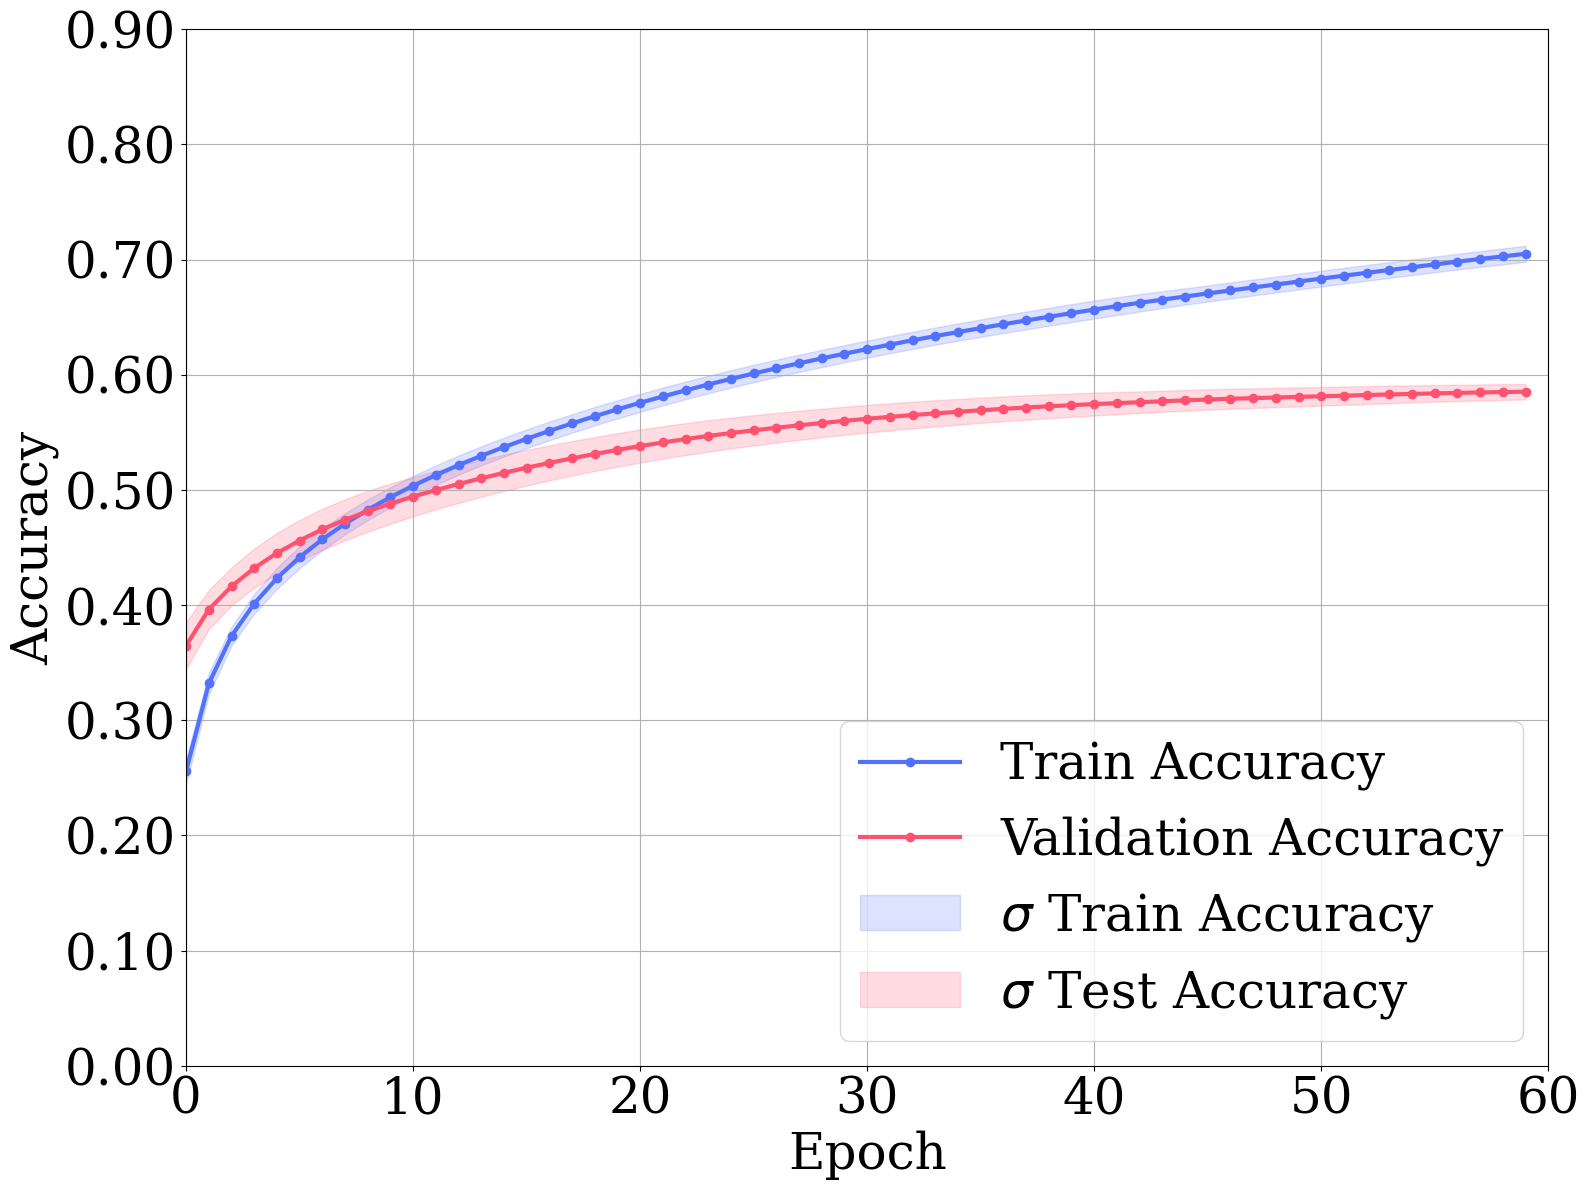

In [ ]:
# Gráfica de precisión

fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(epochs),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(epochs),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ Test Accuracy',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim([0, 0.9])
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModeloLBA' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 60
acc_train = []
acc_val = []
histories = []

time_start_total = time.time()
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'\nEntrenando pliegue {i+1}')

    # Crear modelo nuevo por pliegue

    n_blocks = 6  # Número de bloques residuales convolucionales
    filters = 32  # Número de filtros
    kernel_size = (3, 3)  # Tamaño del kernel
    regularization = l.l2(0)  # Regularización L2
    dropout = 0 # Tasa de desconeción

    model = load_model(n=n_blocks,
                       filters=filters,
                       kernel_size=kernel_size,
                       regular_l=regularization,
                       dropout_rate=dropout)


    # Datos del fold
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenamiento con regularización dinámica
    history, model = train_model_with_dynamic_reg(
        model, X_train_fold, y_train_fold, X_val_fold, y_val_fold,
        epochs=epochs, regularization_flag = True
    )


    histories.append(history)
    # Guardar métricas y historial

    acc_final_train = history['accuracy'][-1]
    acc_final_val = history['val_accuracy'][-1]

    acc_train.append(acc_final_train)
    acc_val.append(acc_final_val)

    print(f'Pliegue {i+1} - Accuracy: {acc_final_train:.4f} - Val Accuracy: {acc_final_val:.4f}')

time_end_total = time.time()
# Resultados finales
print(f'\nMean Train Accuracy: {np.mean(acc_train):.4f} ± {np.std(acc_train):.4f}')
print(f'Mean Val Accuracy: {np.mean(acc_val):.4f} ± {np.std(acc_val):.4f}')
print(f'Total Time:{time_end_total-time_start_total:.0f}')
print(f'-------------------------------------------------------------')


Entrenando pliegue 1

Epoca 1/60
Loss: 9.7692 (Reg: 7.6370), Val Loss: 2.0420
Acc: 0.1988999992609024, Val Acc: 0.27459999918937683

Epoca 2/60
Loss: 4.8432 (Reg: 3.0710), Val Loss: 1.7590
Acc: 0.27322500944137573, Val Acc: 0.3292999863624573

Epoca 3/60
Loss: 4.3794 (Reg: 2.7536), Val Loss: 1.6106
Acc: 0.3251333236694336, Val Acc: 0.3623333275318146

Epoca 4/60
Loss: 2.8799 (Reg: 1.3258), Val Loss: 1.5523
Acc: 0.35922500491142273, Val Acc: 0.3837999999523163

Epoca 5/60
Loss: 2.0778 (Reg: 0.5820), Val Loss: 1.5202
Acc: 0.38363999128341675, Val Acc: 0.3988800048828125

Epoca 6/60
Loss: 1.8291 (Reg: 0.3790), Val Loss: 1.4712
Acc: 0.4027416706085205, Val Acc: 0.4114333391189575

Epoca 7/60
Loss: 1.6426 (Reg: 0.2263), Val Loss: 1.4333
Acc: 0.4187428653240204, Val Acc: 0.4229142963886261

Epoca 8/60
Loss: 1.5829 (Reg: 0.2063), Val Loss: 1.4049
Acc: 0.4327687621116638, Val Acc: 0.4342750012874603

Epoca 9/60
Loss: 1.4698 (Reg: 0.1503), Val Loss: 1.3676
Acc: 0.44530001282691956, Val Acc: 0.

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

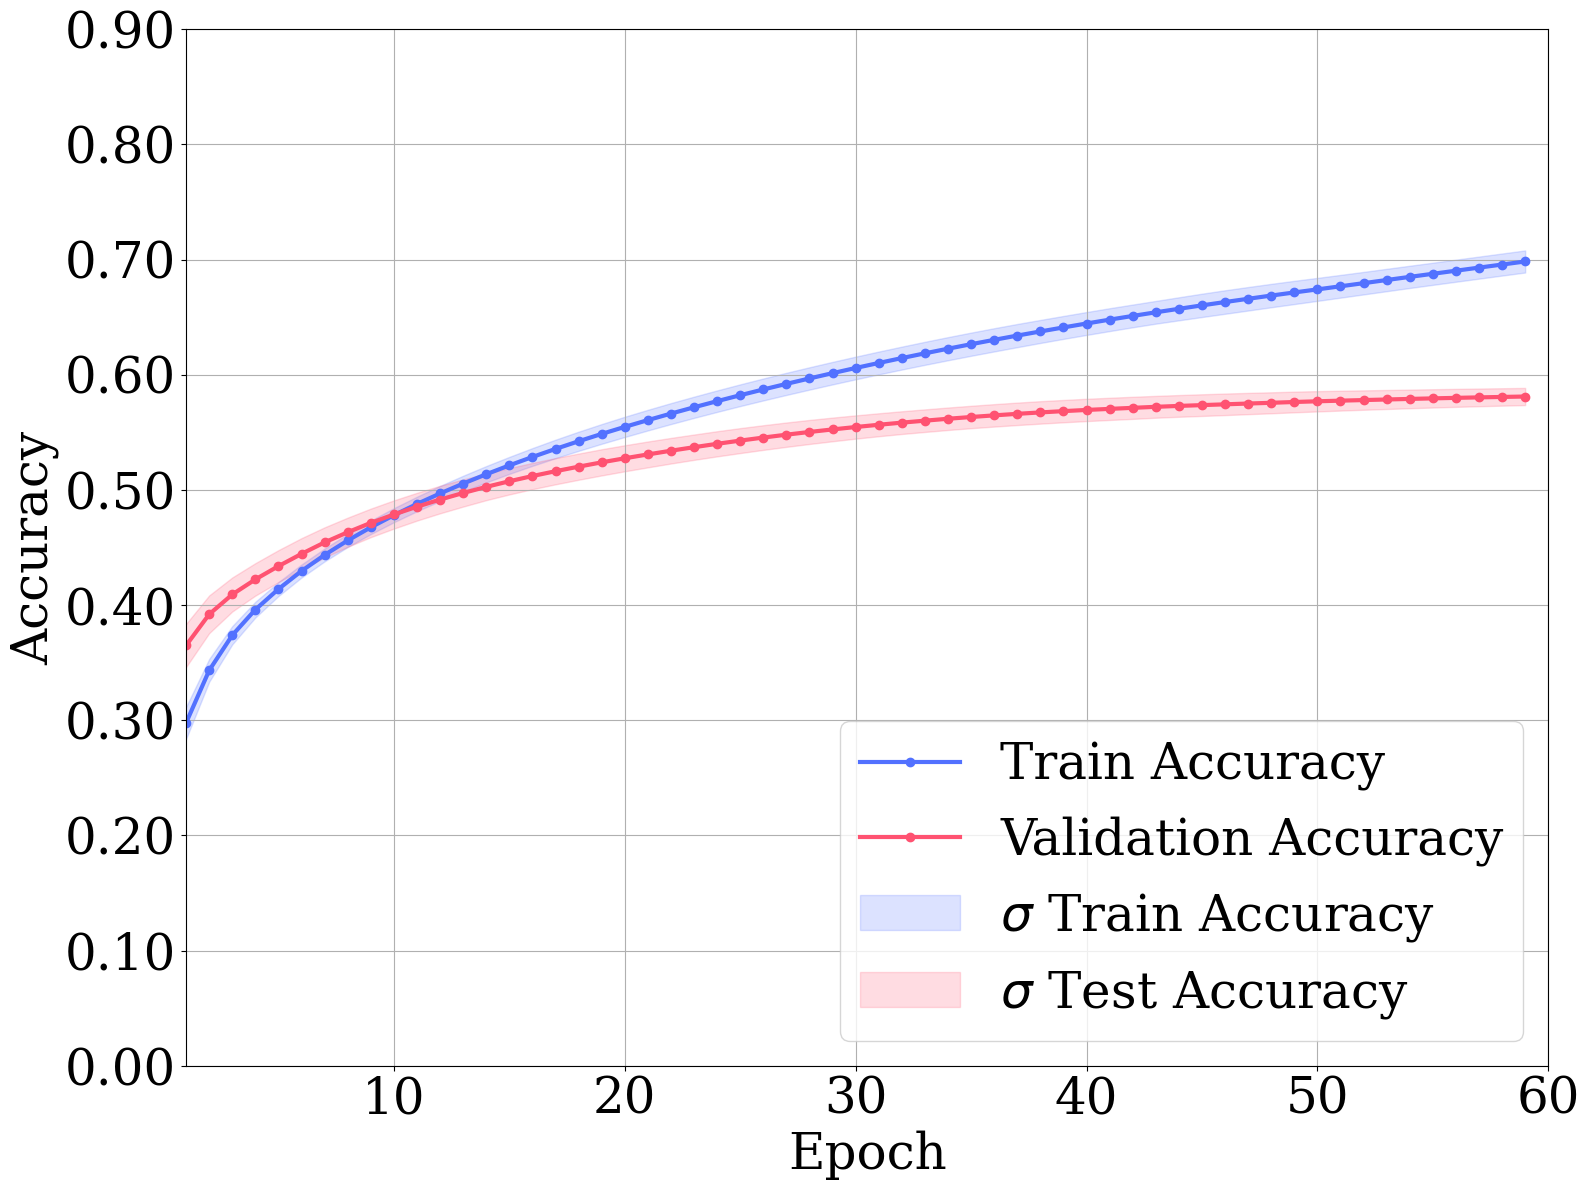

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.plot(train_acc_mean, '#5271ff', linestyle = "-", marker = "o",
          label='Train Accuracy', lw = 3)
plt.plot(val_acc_mean,  '#ff5271',
          label='Validation Accuracy', linestyle = '-', marker = 'o', lw = 3)
plt.fill_between(range(epochs),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 label = r'$\sigma$ Train Accuracy',
                 alpha=0.2, color = '#5271ff')

plt.fill_between(range(epochs),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 label = r'$\sigma$ Test Accuracy',
                 alpha=0.2, color = '#ff5271')
plt.xlabel('Epoch',fontsize=36)
plt.ylabel(r'Accuracy',fontsize=36)
plt.xlim([1, epochs])
plt.ylim([0, 0.9])
plt.grid()
plt.legend(fontsize=36,loc = 'lower right')
plt.xticks(np.arange(10, epochs+1, step=10), fontsize=36)
plt.yticks(fontsize=36)
plt.tight_layout()
nameFile = 'presicionModeloLBA2' +'.pdf'
plt.tight_layout()
plt.savefig(nameFile)

# Modelo con regularización L2

## Sintonización hiperparámetro

In [ ]:
# Definir la rejilla de hiperparámetros
param_grid = [l2(0.1), l2(0.01), l2(0.001), l2(0.0001)]
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# Ajuste de hiperparámetros
for param in param_grid:
    print(f'Probando regularización L2: {param.l2}')
    acc_train = []
    acc_test = []

    for train_index, test_index in kf.split(X_train):
        model = load_model(n=n_blocks, filters=filters, kernel_size=kernel_size, regular_l=param)

        model.compile(
            loss='categorical_crossentropy',
            optimizer='SGD',
            metrics=['accuracy']
        )
        # Entrenamiento
        model.fit(
            X_train[train_index],
            y_train_onehot[train_index],
            epochs=30,
            verbose=0
        )
        # Evaluación
        train_acc = model.evaluate(X_train[train_index], y_train_onehot[train_index], verbose=0)[1]
        test_acc = model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose=0)[1]
        acc_train.append(train_acc)
        acc_test.append(test_acc)
        print(f'Pliegue: Accuracy Entrenamiento: {train_acc:.4f}, Prueba: {test_acc:.4f}')

    # Promedios y desviación estándar
    print(f'Promedio Entrenamiento: {np.mean(acc_train):.4f}, Desviación: {np.std(acc_train):.4f}')
    print(f'Promedio Prueba: {np.mean(acc_test):.4f}, Desviación: {np.std(acc_test):.4f}')
    print('-' * 50)

Probando regularización L2: 0.1
Pliegue: Accuracy Entrenamiento: 0.2810, Prueba: 0.2684
Pliegue: Accuracy Entrenamiento: 0.3055, Prueba: 0.2817
Pliegue: Accuracy Entrenamiento: 0.3339, Prueba: 0.3057
Promedio Entrenamiento: 0.3068, Desviación: 0.0216
Promedio Prueba: 0.2853, Desviación: 0.0154
--------------------------------------------------
Probando regularización L2: 0.01
Pliegue: Accuracy Entrenamiento: 0.7430, Prueba: 0.5030
Pliegue: Accuracy Entrenamiento: 0.6375, Prueba: 0.4710
Pliegue: Accuracy Entrenamiento: 0.7144, Prueba: 0.4848
Promedio Entrenamiento: 0.6983, Desviación: 0.0446
Promedio Prueba: 0.4863, Desviación: 0.0131
--------------------------------------------------
Probando regularización L2: 0.001
Pliegue: Accuracy Entrenamiento: 0.9475, Prueba: 0.5414
Pliegue: Accuracy Entrenamiento: 0.7558, Prueba: 0.4677
Pliegue: Accuracy Entrenamiento: 0.9060, Prueba: 0.5317
Promedio Entrenamiento: 0.8698, Desviación: 0.0823
Promedio Prueba: 0.5136, Desviación: 0.0327
----------

## Entrenamiento mejor parámetro

In [ ]:
regularization = l.l2(0.0001)  # Regularización con el mejor parametro L2

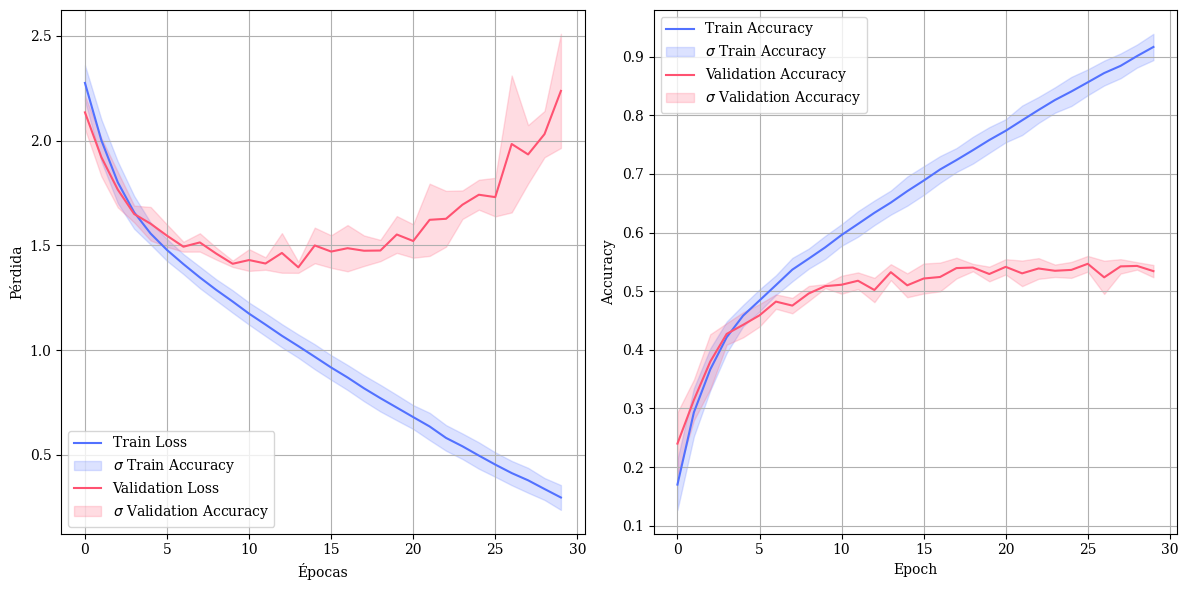

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_mean, label='Train Loss', color='#5271ff')
plt.fill_between(range(epochs),
                 train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std,
                 color='#5271ff', alpha=0.2,
                 label = r'$\sigma$ Train Accuracy')
plt.plot(val_loss_mean, label='Validation Loss', color='#ff5271')
plt.fill_between(range(epochs),
                 val_loss_mean - val_loss_std,
                 val_loss_mean + val_loss_std,
                 color='#ff5271', alpha=0.2,
                 label = r'$\sigma$ Validation Accuracy')

plt.grid()
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(train_acc_mean, label='Train Accuracy', color='#5271ff')
plt.fill_between(range(epochs),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 color='#5271ff', alpha=0.2,
                 label = r'$\sigma$ Train Accuracy')
plt.plot(val_acc_mean, label='Validation Accuracy', color='#ff5271')
plt.fill_between(range(epochs),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 color='#ff5271', alpha=0.2,
                 label = r'$\sigma$ Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



---



# Modelo con dropout

In [ ]:
def skip_connection(conv_input, n, filters, kernel_size, regularizer, dropout_rate):
    """
    Crea capas convolucionales con conexiones residuales y dropout.

    Args:
        conv_input: Tensor de entrada.
        n: Número de bloques residuales.
        filters: Número de filtros para las capas convolucionales.
        kernel_size: Tamaño del kernel.
        regularizer: Regularizador L1 o L1_L2.
        dropout_rate: Tasa de dropout.

    Returns:
        Tensor de salida con conexiones residuales.
    """
    if n >= 2:
        # Capa convolucional con dropout
        res_conv = Dropout(dropout_rate)(Conv2D(
            filters, kernel_size, activation='relu', padding='same', kernel_regularizer=regularizer
        )(conv_input))
        # Conexión residual
        return skip_connection(Add()([conv_input, res_conv]), n - 1, filters, kernel_size, regularizer, dropout_rate)

    # Última capa convolucional con dropout
    res_conv_final = Dropout(dropout_rate)(Conv2D(
        filters, kernel_size, activation='relu', padding='same', kernel_regularizer=regularizer
    )(conv_input))

    # Retorno final con conexión residual
    return Add()([conv_input, res_conv_final])

# Función para cargar el modelo
def load_model(n, filters, kernel_size, regular_l1, dropout_rate):
    """
    Construye un modelo con capas convolucionales, conexiones residuales, dropout y regularización.

    Args:
        n: Número de bloques residuales.
        filters: Número de filtros en las capas convolucionales.
        kernel_size: Tamaño del kernel.
        regular_l1: Regularización L1 o L1_L2.
        dropout_rate: Tasa de dropout.

    Returns:
        Modelo compilado de TensorFlow.
    """
    tf.keras.backend.clear_session()

    # Entrada para imágenes de CIFAR-10 (32x32x3)
    inputs = Input(shape=(32, 32, 3))

    # Primera capa convolucional
    conv1 = Dropout(dropout_rate)(Conv2D(
        filters, kernel_size, activation='relu', padding='same', kernel_regularizer=regular_l1
    )(inputs))

    # Capas residuales
    skip_final = skip_connection(conv1, n, filters, kernel_size, regular_l1, dropout_rate)

    # Pooling y capa densa final
    pool = MaxPooling2D(pool_size=(2, 2))(skip_final)
    flat = Flatten()(pool)
    outputs = Dense(10, activation='softmax', kernel_regularizer=regular_l1)(flat)

    return Model(inputs=inputs, outputs=outputs, name='ConvNetCustomModel')

### Sintonización hiperparámetro

In [ ]:
param_grid = [ 0.2, 0.4, 0.6, 0.8]
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
# Ajuste de hiperparámetros
for param in param_grid:
    print(f'Probando regularización Dropout: {param}')
    acc_train = []
    acc_test = []

    for train_index, test_index in kf.split(X_train):
        model = load_model(n=n_blocks, filters=filters,
                           kernel_size=kernel_size, regular_l1=l2(0),
                           dropout_rate= param)

        model.compile(
            loss='categorical_crossentropy',
            optimizer='SGD',
            metrics=['accuracy']
        )
        # Entrenamiento
        model.fit(
            X_train[train_index],
            y_train_onehot[train_index],
            epochs=30,
            verbose=0
        )
        # Evaluación
        train_acc = model.evaluate(X_train[train_index], y_train_onehot[train_index], verbose=0)[1]
        test_acc = model.evaluate(X_train[test_index], y_train_onehot[test_index], verbose=0)[1]
        acc_train.append(train_acc)
        acc_test.append(test_acc)
        print(f'Pliegue: Accuracy Entrenamiento: {train_acc:.4f}, Prueba: {test_acc:.4f}')

    # Promedios y desviación estándar
    print(f'Promedio Entrenamiento: {np.mean(acc_train):.4f}, Desviación: {np.std(acc_train):.4f}')
    print(f'Promedio Prueba: {np.mean(acc_test):.4f}, Desviación: {np.std(acc_test):.4f}')
    print('-' * 50)

Probando regularización Dropout: 0.2
Pliegue: Accuracy Entrenamiento: 0.7075, Prueba: 0.4883
Pliegue: Accuracy Entrenamiento: 0.7957, Prueba: 0.4866
Pliegue: Accuracy Entrenamiento: 0.6783, Prueba: 0.4569
Promedio Entrenamiento: 0.7271, Desviación: 0.0499
Promedio Prueba: 0.4773, Desviación: 0.0144
--------------------------------------------------
Probando regularización Dropout: 0.4
Pliegue: Accuracy Entrenamiento: 0.5611, Prueba: 0.4427
Pliegue: Accuracy Entrenamiento: 0.5569, Prueba: 0.4407
Pliegue: Accuracy Entrenamiento: 0.6103, Prueba: 0.4740
Promedio Entrenamiento: 0.5761, Desviación: 0.0243
Promedio Prueba: 0.4525, Desviación: 0.0153
--------------------------------------------------
Probando regularización Dropout: 0.6
Pliegue: Accuracy Entrenamiento: 0.4637, Prueba: 0.3803
Pliegue: Accuracy Entrenamiento: 0.3985, Prueba: 0.3171
Pliegue: Accuracy Entrenamiento: 0.3459, Prueba: 0.2928
Promedio Entrenamiento: 0.4027, Desviación: 0.0482
Promedio Prueba: 0.3301, Desviación: 0.036

In [ ]:
# Configuración de KFold y parámetros
kf = KFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
acc_train = []
acc_test = []
histories = []  # Para guardar los historiales de cada pliegue

# Iterar sobre los pliegues
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    print(f'Entrenando pliegue {i+1}')

    # Crear y compilar el modelo para cada pliegue
    model = load_model(n=n_blocks, filters=filters, kernel_size=kernel_size,
                       regular_l1=l2(0), dropout_rate=0.2)
    model.compile(
        loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy']
    )

    # Dividir los datos en entrenamiento y prueba
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train_onehot[train_index], y_train_onehot[test_index]

    # Entrenar el modelo
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_test_fold, y_test_fold),
        epochs=epochs,
        verbose=1
    )

    # Evaluar el modelo
    train_eval = model.evaluate(X_train_fold, y_train_fold, verbose=0)
    test_eval = model.evaluate(X_test_fold, y_test_fold, verbose=0)

    # Guardar métricas y historial
    acc_train.append(train_eval[1])
    acc_test.append(test_eval[1])
    histories.append(history.history)

    print(f'Pliegue {i+1}: Accuracy Entrenamiento = {train_eval[1]:.4f}, Accuracy Prueba = {test_eval[1]:.4f}')

# Resumen final
print(f'\nPromedio Accuracy Entrenamiento: {np.mean(acc_train):.4f}, STD: {np.std(acc_train):.4f}')
print(f'Promedio Accuracy Prueba: {np.mean(acc_test):.4f}, STD: {np.std(acc_test):.4f}')

Entrenando pliegue 1
Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - accuracy: 0.1103 - loss: 2.5670 - val_accuracy: 0.1045 - val_loss: 2.3066
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.1488 - loss: 2.2460 - val_accuracy: 0.2425 - val_loss: 2.0312
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2556 - loss: 2.0115 - val_accuracy: 0.2770 - val_loss: 1.9522
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3335 - loss: 1.8925 - val_accuracy: 0.2915 - val_loss: 1.9263
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3537 - loss: 1.7838 - val_accuracy: 0.4140 - val_loss: 1.6945
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4123 - loss: 1.6676 - val_accuracy: 0.4130 - val_loss: 1.6496
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4401 - loss: 1.5805 - val_accuracy: 0.4420 - val_loss: 1.5737
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4578 - l

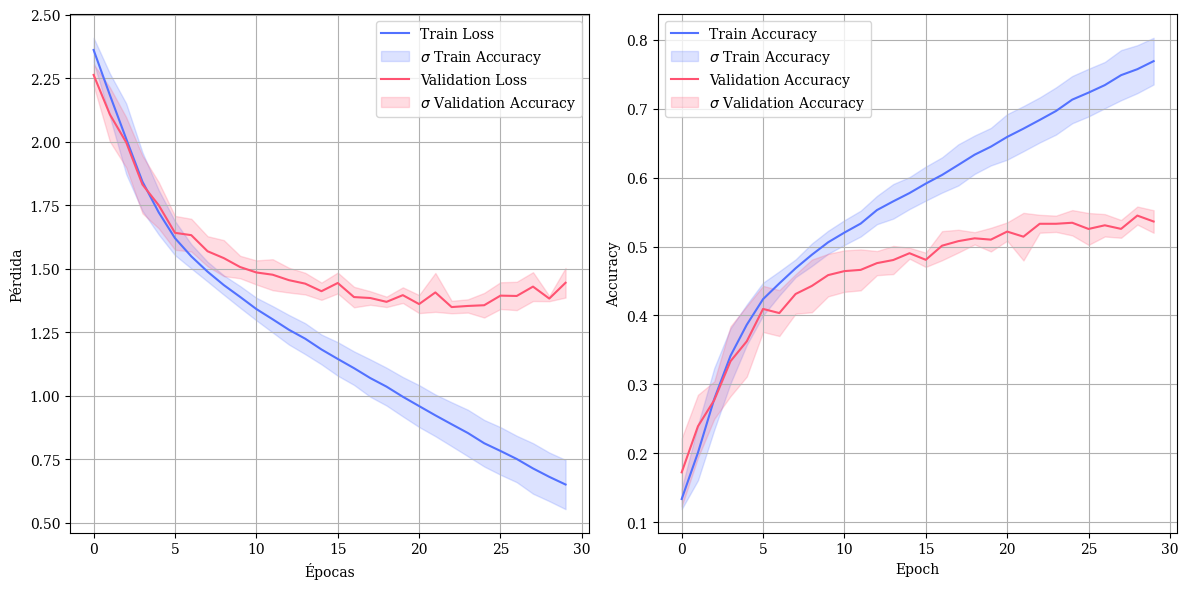

In [ ]:
# Inicializar listas para almacenar las métricas por época
epochs = len(histories[0]['loss'])
train_loss_all = np.zeros((len(histories), epochs))
val_loss_all = np.zeros((len(histories), epochs))
train_acc_all = np.zeros((len(histories), epochs))
val_acc_all = np.zeros((len(histories), epochs))

# Extraer métricas de cada pliegue
for i, history in enumerate(histories):
    train_loss_all[i, :] = history['loss']
    val_loss_all[i, :] = history['val_loss']
    train_acc_all[i, :] = history['accuracy']
    val_acc_all[i, :] = history['val_accuracy']

# Promedio y desviación estándar
train_loss_mean = np.mean(train_loss_all, axis=0)
train_loss_std = np.std(train_loss_all, axis=0)
val_loss_mean = np.mean(val_loss_all, axis=0)
val_loss_std = np.std(val_loss_all, axis=0)

train_acc_mean = np.mean(train_acc_all, axis=0)
train_acc_std = np.std(train_acc_all, axis=0)
val_acc_mean = np.mean(val_acc_all, axis=0)
val_acc_std = np.std(val_acc_all, axis=0)

# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss_mean, label='Train Loss', color='#5271ff')
plt.fill_between(range(epochs),
                 train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std,
                 color='#5271ff', alpha=0.2,
                 label = r'$\sigma$ Train Accuracy')
plt.plot(val_loss_mean, label='Validation Loss', color='#ff5271')
plt.fill_between(range(epochs),
                 val_loss_mean - val_loss_std,
                 val_loss_mean + val_loss_std,
                 color='#ff5271', alpha=0.2,
                 label = r'$\sigma$ Validation Accuracy')

plt.grid()
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(train_acc_mean, label='Train Accuracy', color='#5271ff')
plt.fill_between(range(epochs),
                 train_acc_mean - train_acc_std,
                 train_acc_mean + train_acc_std,
                 color='#5271ff', alpha=0.2,
                 label = r'$\sigma$ Train Accuracy')
plt.plot(val_acc_mean, label='Validation Accuracy', color='#ff5271')
plt.fill_between(range(epochs),
                 val_acc_mean - val_acc_std,
                 val_acc_mean + val_acc_std,
                 color='#ff5271', alpha=0.2,
                 label = r'$\sigma$ Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()